In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from itertools import combinations
import random

def compute_error_rates(true_labels, pred_labels):
    """Compute APCER, BPCER, ACER."""
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    # Define mapping
    labels = [0, 1]  # Ensure consistent order

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)
    #print(cm)
    TN, FP, FN, TP = cm.ravel()  # Unpack the matrix

    apcer = FN/(FN+TP)
    bpcer = FP/(FP+TN)
    acer = 0.5 * (apcer + bpcer)
    return acer, apcer, bpcer

def get_fold_data(df, train_folds: list = [], val_folds: list = [], df_syn = pd.DataFrame(), amount_syn = 0):
    amount_auth = max(0, len(train_folds) - amount_syn)
    auth_folds = train_folds[:amount_auth]
    syn_folds = train_folds[amount_auth:]
    
    train_df_auth = df[df['fold'].isin(auth_folds)]
    if not df_syn.empty:
        train_df_syn = df_syn[df_syn['fold'].isin(syn_folds)]
        train_df = pd.concat([train_df_auth, train_df_syn])
    else:
        train_df = train_df_auth
    
    val_df = df[df['fold'].isin(val_folds)]

    X_train = np.stack(train_df['features'].values)
    X_val = np.stack(val_df['features'].values)

    y_train = train_df['label']
    y_val = val_df['label']

    return X_train, y_train, X_val, y_val

def to_result_tuple(k, method, category, acer, apcer, bpcer):
    return [
        (k, method, 'ACER', category, acer),
        (k, method, 'APCER', category, apcer),
        (k, method, 'BPCER', category, bpcer),
    ]

def crossvalidation(df, k=5, method='xxxx', df_syn = pd.DataFrame()):
    folds = {0, 1, 2, 3, 4}
    errors = []
    
    for i in range(0, 5):
        train_folds_list = list({0, 1, 2, 3, 4} - {i})
        random.shuffle(train_folds_list)

        # train = 4/5, val = 1/5
        X_train, y_train, X_val, y_val = get_fold_data(df, train_folds = train_folds_list[:4], val_folds=[i])
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        predictions = knn.predict(X_val)
        errors.extend(to_result_tuple(k, method, '4/5', *compute_error_rates(y_val, predictions)))

        # train = 2/5, val = 1/5
        X_train, y_train, X_val, y_val = get_fold_data(df, train_folds = train_folds_list[:2], val_folds=[i])
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        predictions = knn.predict(X_val)
        errors.extend(to_result_tuple(k, method, '2/5', *compute_error_rates(y_val, predictions)))

        # train = 1/5, val = 1/5
        X_train, y_train, X_val, y_val = get_fold_data(df, train_folds = train_folds_list[:1], val_folds=[i])
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        predictions = knn.predict(X_val)
        errors.extend(to_result_tuple(k, method, '1/5', *compute_error_rates(y_val, predictions)))

        if not df_syn.empty:
            # train = 1+1/5, val = 1/5
            X_train, y_train, X_val, y_val = get_fold_data(df, train_folds = train_folds_list[:2], val_folds=[i], df_syn = df_syn, amount_syn = 1)
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            predictions = knn.predict(X_val)
            errors.extend(to_result_tuple(k, method, '(1+1)/5', *compute_error_rates(y_val, predictions)))

            # train = 1+3/5, val = 1/5
            X_train, y_train, X_val, y_val = get_fold_data(df, train_folds = train_folds_list[:4], val_folds=[i], df_syn = df_syn, amount_syn = 3)
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            predictions = knn.predict(X_val)
            errors.extend(to_result_tuple(k, method, '(1+3)/5', *compute_error_rates(y_val, predictions)))

    return errors

In [23]:
dataset_title = 'PLUS'
metrics = ['ACER', 'APCER', 'BPCER']
ks = [3, 5, 7, 9]
lbp_settings = [
    { 'P': 8, 'R': 1, 'method': 'default', 'title': 'Default' },
    { 'P': 8, 'R': 1, 'method': 'ror', 'title': 'Rotation Invariant' },
    { 'P': 8, 'R': 1, 'method': 'uniform', 'title': 'Uniform' },
    { 'P': 8, 'R': 1, 'method': 'nri_uniform', 'title': 'Uniform Grayscale Invariant' },
    { 'P': 8, 'R': 1, 'method': 'var', 'title': 'Contrast Variance' },
]

In [24]:
feature_dfs = [pd.read_pickle(file) for file in [f'{dataset_title}_lbp-{s['method']}.pkl' for s in lbp_settings]]
feature_dfs_vae = [pd.read_pickle(file) for file in [f'{dataset_title}-VAE_lbp-{s['method']}.pkl' for s in lbp_settings]]
feature_dfs_ae = [pd.read_pickle(file) for file in [f'{dataset_title}-AE_lbp-{s['method']}.pkl' for s in lbp_settings]]

In [25]:
def calculate(dfs_auth, dfs_syn):
    data = []
    for auth, syn, setting in zip(dfs_auth, dfs_syn, lbp_settings):
        for k in ks:
            data.extend(crossvalidation(auth, k, setting['method'], syn))

    return pd.DataFrame(data, columns=['k', 'method', 'Error_Class', 'Category', 'Value'])

def plot(dfs_auth, dfs_syn):
    df = calculate(dfs_auth, dfs_syn)

    # 1. Setup dimensions
    ks = [3, 5, 7, 9]
    methods = ['default', 'ror', 'uniform', 'nri_uniform', 'var']
    error_classes = ['ACER', 'APCER', 'BPCER']
    
    # 2. Initialize the figure
    fig, axes = plt.subplots(nrows=len(ks), ncols=len(methods), 
                             figsize=(18, 12), sharey=True, constrained_layout=True)
    
    # 3. Loop through the grid
    for i, k_val in enumerate(ks):
        for j, method_val in enumerate(methods):
            ax = axes[i, j]
            
            # Filter data for this specific subplot
            subset = df[(df['k'] == k_val) & (df['method'] == method_val)]
            
            # Plotting
            sns.barplot(
                data=subset, 
                x='Error_Class', 
                y='Value', 
                hue='Category', 
                ax=ax,
                palette='viridis',
                errorbar = None
            )
            
            # Formatting titles and labels
            if i == 0:
                ax.set_title(f"Method: {method_val.upper()}", fontsize=14, fontweight='bold')
            if j == 0:
                ax.set_ylabel(f"k = {k_val}\nError Rate", fontsize=12, fontweight='bold')
            else:
                ax.set_ylabel("")
                
            # Clean up legends: only show one legend for the whole figure or per row
            if not (i == 0 and j == len(methods) - 1):
                ax.get_legend().remove()
            else:
                ax.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()
    return fig

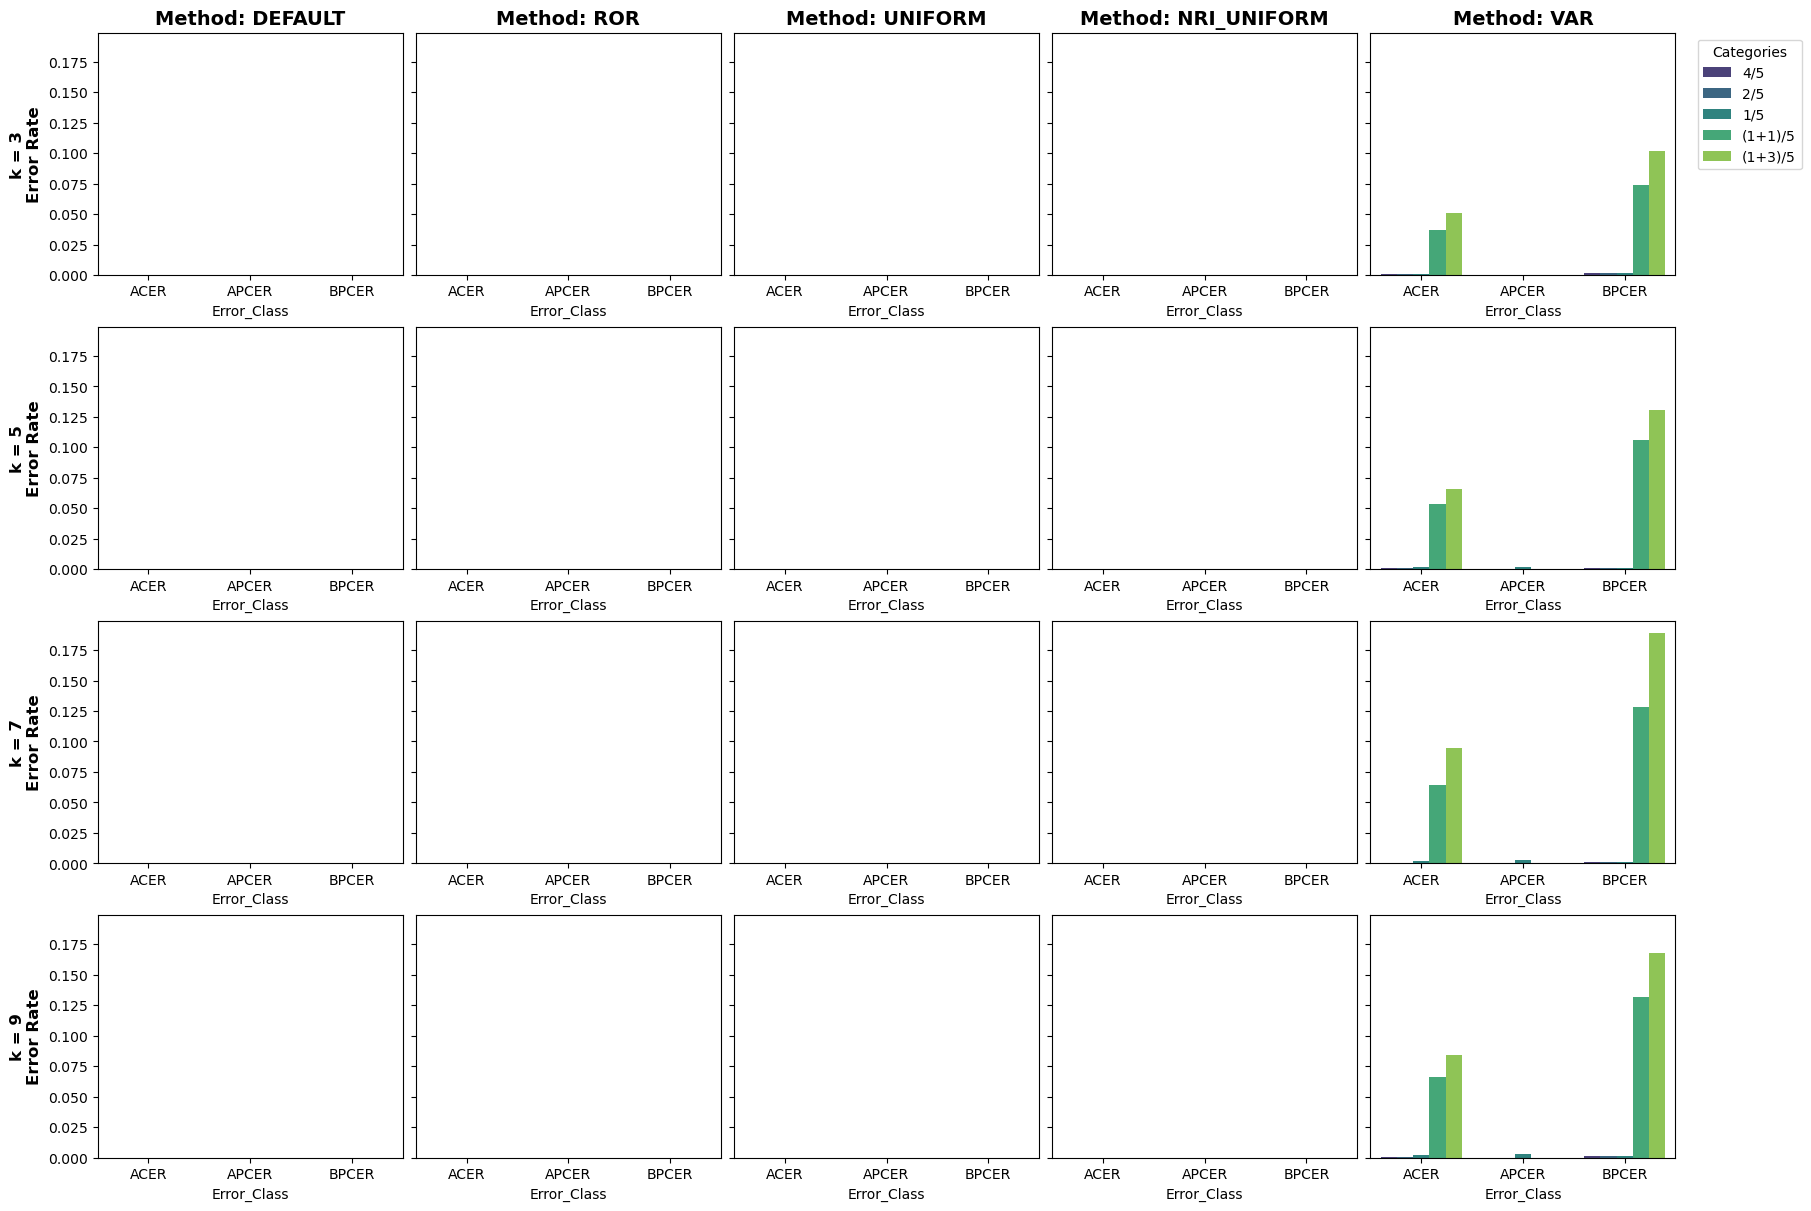

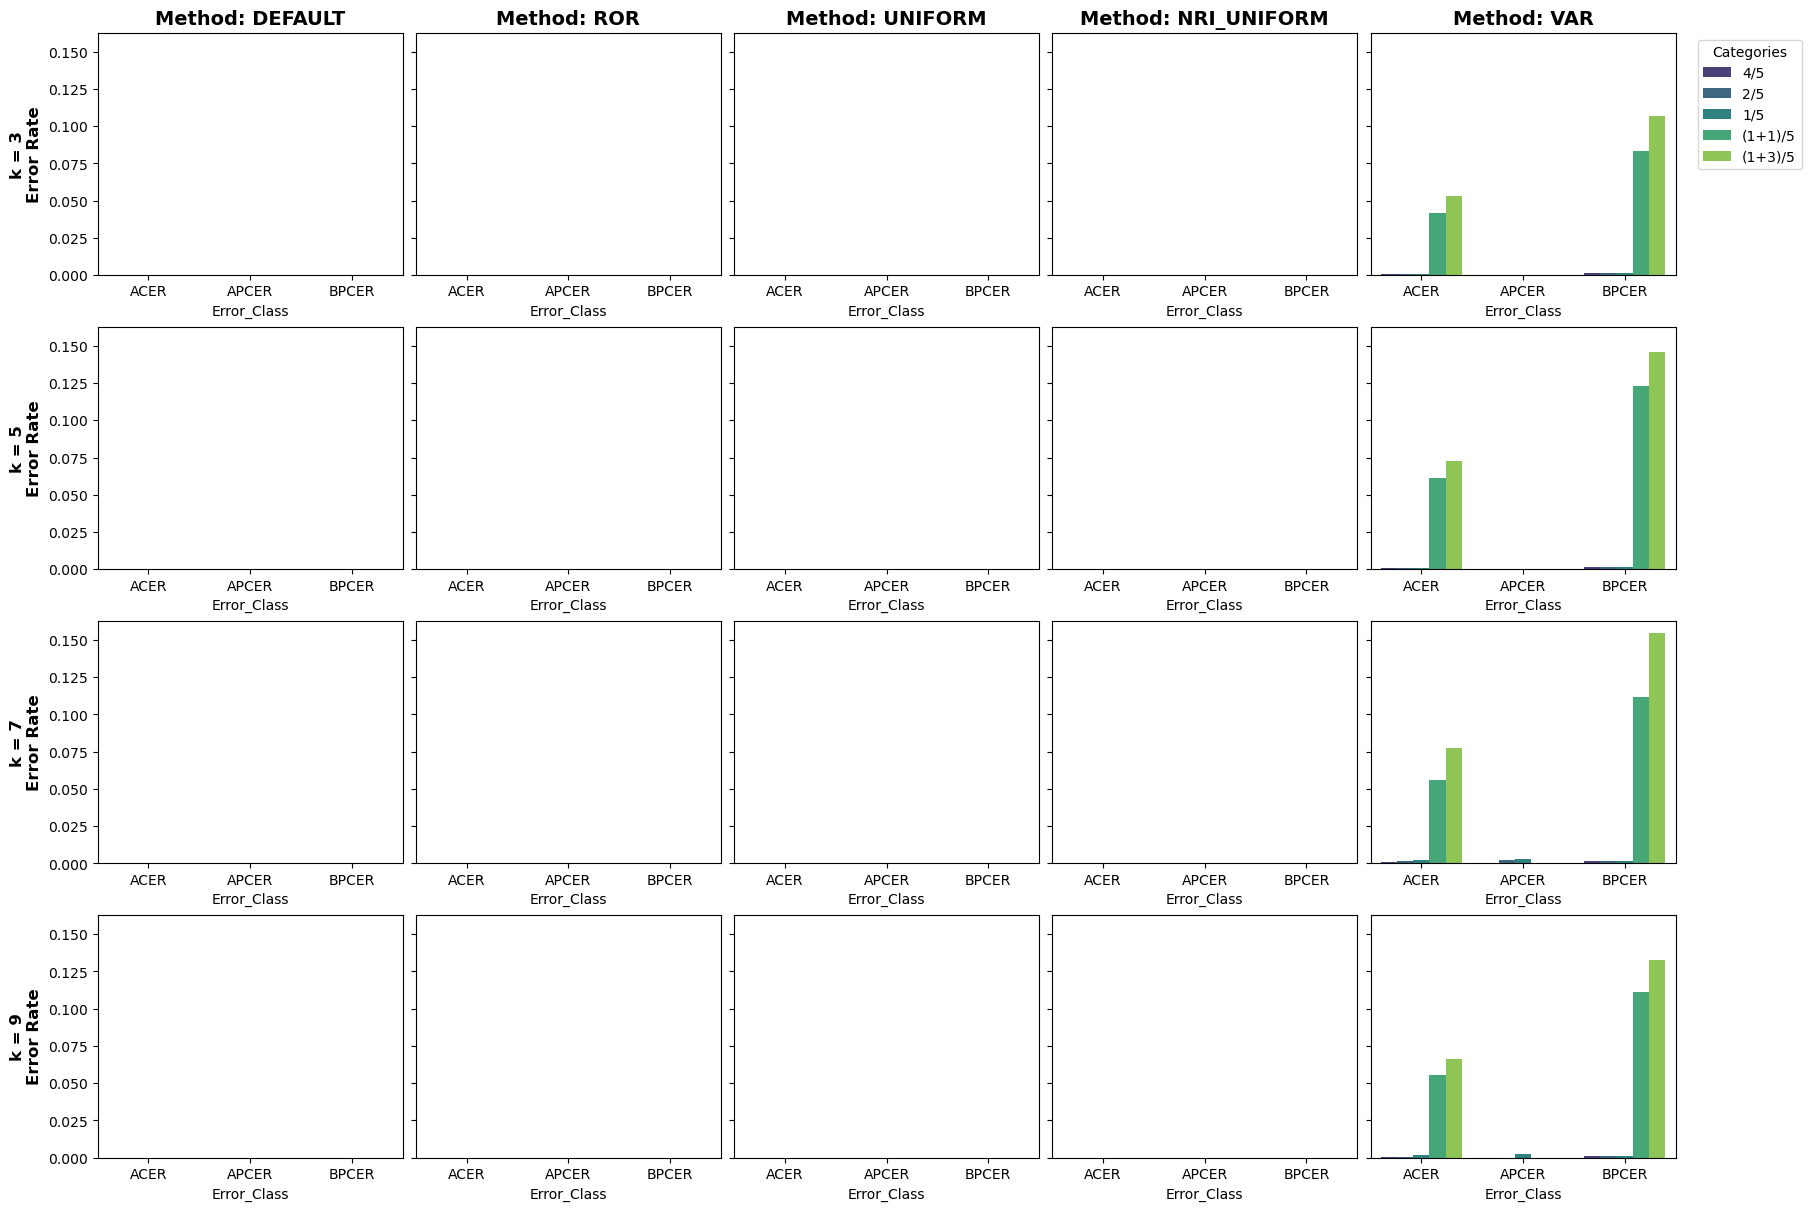

In [27]:
fig = plot(feature_dfs, feature_dfs_vae)
#fig.savefig(dataset_title + '-VAE' + '.pdf', format="pdf")
fig = plot(feature_dfs, feature_dfs_ae)
#fig.savefig(dataset_title + '-AE' + '.pdf', format="pdf")

In [50]:
from datetime import datetime

# Get current time
now = datetime.now()

# Format: results_DD-MM-YYYY_HH-MM-SS
filename = now.strftime("results_%d-%m-%Y_%H-%M-%S.pdf")
fig.savefig(filename, format="pdf")

NameError: name 'fig' is not defined

In [ ]:
fig, axes = plt.subplots(nrows=len(ks), ncols=len(feature_dfs), figsize=(12, 12), sharey=True)
fig.suptitle('Error Rates Across Different Number of Neighbours and LBPs (IDIAP)', fontsize=14)

for r, k in enumerate(ks):
    ax = axes[r]
    if r == 0:
        ax.set_title(lbp_settings[c]['title'])
    errors_df = pd.DataFrame(crossvalidation(feature_dfs[0], k=k, method=df_syn=feature_dfs_vae[0]), columns=metrics)
    sns.barplot(data=errors_df, capsize=.1, ax=ax)

plt.tight_layout()
plt.show()

In [12]:
errors = []
errors.extend(to_result_tuple(3, 'ROR', '1/5', 0.5, 0.1, 0.3))
errors

[(3, 'ROR', 'ACER', '1/5', 0.5),
 (3, 'ROR', 'APCER', '1/5', 0.1),
 (3, 'ROR', 'BPCER', '1/5', 0.3)]